# LSTM on time series

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/lstm1.png" width="1200">



In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

%matplotlib inline

<h3>Step #1. Read data</h3>

In [7]:
from pandas_datareader import data
import fix_yahoo_finance as yf
yf.pdr_override() 

symbol = 'GOOG'
data_source='google'
start_date = '2004-08-19'
end_date = '2020-07-18'
dataset_train = data.get_data_yahoo(symbol, start_date, end_date)
dataset_train = dataset_train.reset_index(level=['Date'])          # index to colum Date
dataset_train

[*********************100%***********************]  1 of 1 downloaded


,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813290,51.835709,47.800831,49.982655,49.982655,44871361
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942874
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342897
3,2004-08-24,55.412300,55.591629,51.591621,52.239197,52.239197,15319808
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232276
...,...,...,...,...,...,...,...
4001,2020-07-13,1550.000000,1577.131958,1505.243042,1511.339966,1511.339966,1846400
4002,2020-07-14,1490.310059,1522.949951,1483.500000,1520.579956,1520.579956,1585000
4003,2020-07-15,1523.130005,1535.329956,1498.000000,1513.640015,1513.640015,1610700
4004,2020-07-16,1500.000000,1518.689941,1486.310059,1518.000000,1518.000000,1519300


In [8]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4006 entries, 0 to 4005
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4006 non-null   datetime64[ns]
 1   Open       4006 non-null   float64       
 2   High       4006 non-null   float64       
 3   Low        4006 non-null   float64       
 4   Close      4006 non-null   float64       
 5   Adj Close  4006 non-null   float64       
 6   Volume     4006 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 219.2 KB


In [9]:
# # Importing Training Set
# dataset_train = pd.read_csv('GOOG.csv')

# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:6]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])
#datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (4006, 7)
All timestamps == 4006
Featured selected: ['Open', 'High', 'Low', 'Close', 'Adj Close']


<h3>Step #2. Data pre-processing</h3>
<p>
Removing all commas and convert data to matrix shape format.
</p>

In [10]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.to_numpy()

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (4006, 5).


array([[  49.81329 ,   51.835709,   47.800831,   49.982655,   49.982655],
       [  50.316402,   54.336334,   50.062355,   53.95277 ,   53.95277 ],
       [  55.168217,   56.528118,   54.321388,   54.495735,   54.495735],
       ...,
       [1523.130005, 1535.329956, 1498.      , 1513.640015, 1513.640015],
       [1500.      , 1518.689941, 1486.310059, 1518.      , 1518.      ],
       [1521.619995, 1523.439941, 1498.420044, 1515.550049, 1515.550049]])

In [12]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-1.27195196],
       [-1.27058974],
       [-1.25745309],
       ...,
       [ 2.71716347],
       [ 2.65453724],
       [ 2.713075  ]])

In [13]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (3857, 90, 4).
y_train shape == (3857, 1).


<h2>PART 2. Create a model. Training</h2>

<h3>Step #3. Building the LSTM based Neural Network</h3>

In [14]:
# Import Libraries and packages from Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LeakyReLU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard


In [16]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=128, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))
model.add(LeakyReLU(alpha=0.2)) 
# Adding 2nd LSTM layer
model.add(LSTM(units=16, return_sequences=False))
#model.add(LeakyReLU(alpha=0.2)) 
# Adding Dropout
model.add(Dropout(0.5))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.001), loss='mse')

<h3>Step #4. Start training</h3>

In [17]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, 
                    y_train, 
                    shuffle=True, 
                    epochs=30, 
                    callbacks=[es, rlr, mcp, tb], 
                    validation_split=0.2, 
                    verbose=1, 
                    batch_size=200)

Epoch 1/30
16/16 [==============================] - 10s 460ms/step - loss: 0.1959 - val_loss: 0.4570

Epoch 00001: val_loss improved from inf to 0.45704, saving model to weights.h5
Epoch 2/30
16/16 [==============================] - 6s 357ms/step - loss: 0.0658 - val_loss: 0.5946

Epoch 00002: val_loss did not improve from 0.45704
Epoch 3/30
16/16 [==============================] - 6s 360ms/step - loss: 0.0523 - val_loss: 0.5345

Epoch 00003: val_loss did not improve from 0.45704
Epoch 4/30
16/16 [==============================] - 6s 357ms/step - loss: 0.0494 - val_loss: 0.4353

Epoch 00004: val_loss improved from 0.45704 to 0.43527, saving model to weights.h5
Epoch 5/30
16/16 [==============================] - 6s 358ms/step - loss: 0.0489 - val_loss: 0.3772

Epoch 00005: val_loss improved from 0.43527 to 0.37715, saving model to weights.h5
Epoch 6/30
16/16 [==============================] - 6s 358ms/step - loss: 0.0449 - val_loss: 0.3573

Epoch 00006: val_loss improved from 0.37715 to

<p>
Notes:<br>
<ul>
<li><b>EarlyStopping</b> - Stop training when a monitored metric has stopped improving.</li>
<li><code>monitor</code> - quantity to be monitored.</li>
<li><code>min_delta</code> - minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than <code>min_delta</code>, will count as no improvement.</li>
<li><code>patience</code> - number of epochs with no improvement after which training will be stopped.</li>
</ul>

<ul>
<li><b>ReduceLROnPlateau</b> - Reduce learning rate when a metric has stopped improving.</li>
<li><code>factor</code> - factor by which the learning rate will be reduced. <code>new_lr = lr * factor</code>.</li>
</ul>
</p>

<hr>

<p>
The last date for our training set is <code>30-Dec-2016</code>.<br>
</p>

<p>
We will perform predictions for the next <b>20</b> days, since <b>2017-01-01</b> to <b>2017-01-20</b>.
</p>

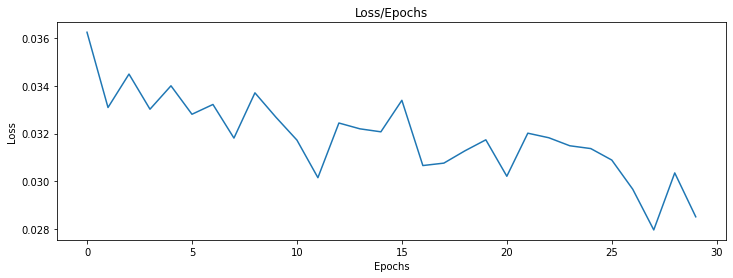

In [ ]:
losses_lstm = history.history['loss']

plt.figure(figsize=(12,4))
plt.title('Loss/Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(len(losses_lstm)),losses_lstm);

<h2>PART 3. Make future predictions</h2>

In [ ]:
datelist_train[-1]

Timestamp('2020-07-17 00:00:00')

In [ ]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [ ]:
datelist_future_[-1] #60 days forward

datetime.date(2020, 9, 14)

<h3>Step #5. Make predictions for future dates</h3>

In [ ]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [ ]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,Open
2005-08-01,156.380661
2005-08-02,157.287430
2005-08-03,158.091782


<h3>Step #6. Visualize the Predictions</h3>

In [ ]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)

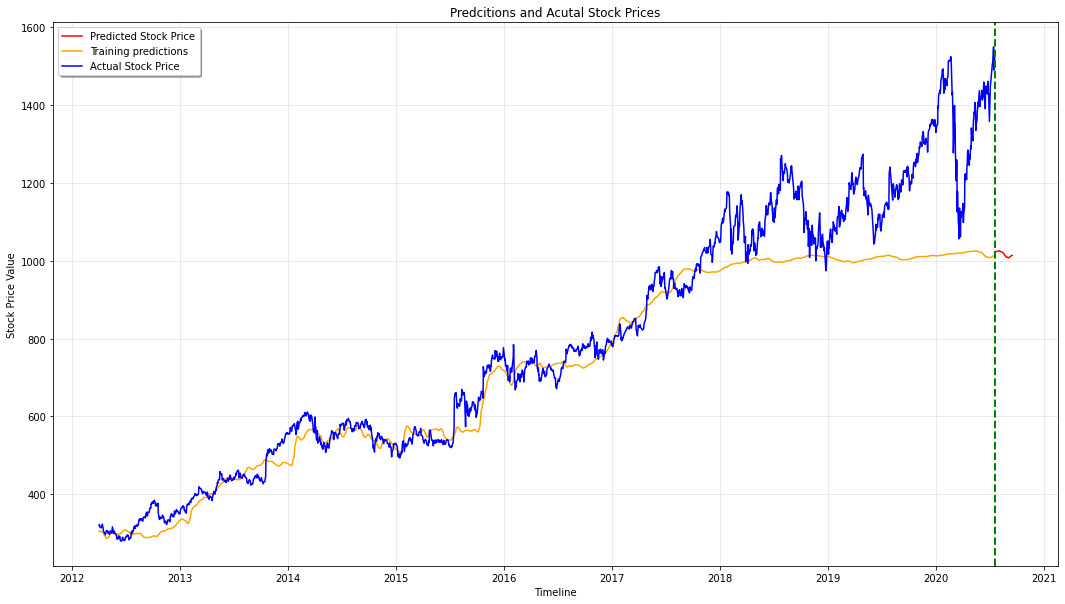

In [ ]:
plt.figure(figsize=(18,10))
# Plot parameters
START_DATE_FOR_PLOTTING = '2012-04-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices',fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
#plt.xticks(rotation=45, fontsize=8)
plt.show()